# Вспомогательные функции

In [16]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
import joblib
from tqdm.notebook import tqdm

from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time

In [4]:
def read_table(table):
    import os
    import astropy.table
    def _drop_multidims(table: astropy.table.Table):
        """
        drop multidimentional columns from astropy.Table so it can be converted to pandas.DataFrame
        """
        singledim_cols = list()
        multidim_cols = list()
        for col in table.colnames:
            if len(table[col].shape) == 1:
                singledim_cols.append(col)
            else:
                multidim_cols.append(col)

        return table[singledim_cols], multidim_cols
    if isinstance(table, str):
        _, ext = os.path.splitext(table)

        if ext == '.gz_pkl':
            try:
                return pd.read_pickle(table, compression='gzip')
            except:
                return pd.read_pickle(table)

        if ext == '.pkl':
            return pd.read_pickle(table)

        if ext == '.fits':
            table = astropy.table.Table.read(table)

    if isinstance(table, pd.DataFrame):
        return table

    if isinstance(table, astropy.table.Table):
        table, dropped_cols = _drop_multidims(table)
        if dropped_cols:
            warnings.warn(
                "multidimentional columns are dropped from table : {}".format(
                    dropped_cols))

        return table.to_pandas()

    raise Exception('Unsupported format of table')

In [5]:
def read_tables(paths_to_files, axis=0):
    import glob
    import os
    return pd.concat([read_table(file) for file in paths_to_files], axis=axis)

In [6]:
def read_tables_in_path(path_to_files, condition, axis=0):
    import glob
    import os
    return pd.concat([read_table(file) for file in glob.glob(os.path.join(path_to_files, condition))], axis=axis)

In [7]:
features_path = '../../models_before_aggregation_j/features.pkl'
column = 'sdssdr16_r_cmodel'
j_features = ['J']
features = pd.read_pickle(features_path) + j_features

In [8]:
sdss_wise = [
                'sdssdr16_u_cmodel-decals8tr_Lw1',
                'sdssdr16_u_cmodel-decals8tr_Lw2',
                'sdssdr16_g_cmodel-decals8tr_Lw1',
                'sdssdr16_g_cmodel-decals8tr_Lw2',
                'sdssdr16_r_cmodel-decals8tr_Lw1',
                'sdssdr16_r_cmodel-decals8tr_Lw2',
                'sdssdr16_i_cmodel-decals8tr_Lw1',
                'sdssdr16_i_cmodel-decals8tr_Lw2',
                'sdssdr16_z_cmodel-decals8tr_Lw1',
                'sdssdr16_z_cmodel-decals8tr_Lw2' 
              ]
sdss_nwise = [
                'sdssdr16_g_cmodel-decals8tr_g',
                'sdssdr16_r_cmodel-decals8tr_r',
                'sdssdr16_z_cmodel-decals8tr_z'
]

ps_decals = [
                'psdr2_g_kron-decals8tr_Lw1',
                'psdr2_g_kron-decals8tr_Lw2',
                'psdr2_r_kron-decals8tr_Lw1',
                'psdr2_r_kron-decals8tr_Lw2',
                'psdr2_i_kron-decals8tr_Lw1',
                'psdr2_i_kron-decals8tr_Lw2',
                'psdr2_z_kron-decals8tr_Lw1',
                'psdr2_z_kron-decals8tr_Lw2',
                'psdr2_y_kron-decals8tr_Lw1',
                'psdr2_y_kron-decals8tr_Lw2'
]

sdss = [i for i in features if 'sdss' in i and 'decals' not in i and column not in i] 
decals = [i for i in features if 'decals' in i and 'sdss' not in i and 'psdr' not in i and column not in i] 
wise = [i for i in decals if 'Lw' in i and column not in i] 
ps = [i for i in features if 'psdr' in i and 'decals' not in i and column not in i]

f0 = {"sdssdr16+wise_decals8tr": sdss+wise+sdss_wise,
     "psdr2+wise_decals8tr": ps+wise+ps_decals,
     "sdssdr16+all_decals8tr": sdss+decals+sdss_wise+sdss_nwise,
     "psdr2+all_decals8tr": ps+decals+ps_decals,
     "decals8tr": decals,
     "sdssdr16+psdr2+wise_decals8tr": sdss+ps+wise+sdss_wise+ps_decals,
     "sdssdr16+psdr2+all_decals8tr": sdss+ps+decals+ps_decals+sdss_wise+sdss_nwise}

sdss_j = [
    'sdssdr16_u_psf-j',
     'sdssdr16_g_psf-j',
     'sdssdr16_r_psf-j',
     'sdssdr16_i_psf-j',
     'sdssdr16_z_psf-j',
     'sdssdr16_u_cmodel-j',
     'sdssdr16_i_cmodel-j'
]

ps_j = [
    'psdr2_i_kron-j',
     'psdr2_y_kron-j',
     'psdr2_g_psf-j',
     'psdr2_r_psf-j',
     'psdr2_i_psf-j',
     'psdr2_z_psf-j',
     'psdr2_y_psf-j'
]

wise_j = [
    'decals8tr_Lw1-j',
     'decals8tr_Lw2-j'
]

nwise_j = [
    'decals8tr_g-j',
     'decals8tr_r-j',
     'decals8tr_z-j'
]


l = [sdss_j, ps_j, wise_j, nwise_j]

f1 = {"sdssdr16+wise_decals8tr": sdss+wise+sdss_wise+sdss_j+wise_j+j_features,
     "psdr2+wise_decals8tr": ps+wise+ps_decals+ps_j+wise_j+j_features,
     "sdssdr16+all_decals8tr": sdss+decals+sdss_wise+sdss_nwise+sdss_j+wise_j+nwise_j+j_features,
     "psdr2+all_decals8tr": ps+decals+ps_decals+ps_j+wise_j+nwise_j+j_features,
     "decals8tr": decals+wise_j+nwise_j+j_features,
     "sdssdr16+psdr2+wise_decals8tr": sdss+ps+wise+sdss_wise+ps_decals+ps_j+wise_j+sdss_j+j_features,
     "sdssdr16+psdr2+all_decals8tr": sdss+ps+decals+ps_decals+sdss_wise+sdss_nwise+sdss_j+nwise_j+ps_j+wise_j+j_features}

f={'not_j': f0, 'j':f1}

In [171]:
def CM(df, model, robust, file_name=None, data ='not_j', norm=False, one=False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    X, y_test = df.drop(columns=['class']).values, df['class'].values
    y_pred_proba = model.predict_proba(X if robust is None else robust.transform(X))[:, 0]
    
    y_pred = 2 - (y_pred_proba >= 0.1) 

#     end = []#'%TP', '%FP', '%TN', '%FN', 'T', 'N'    tn, fp, fn, tp
#     tn, fp, fn, tp = np.around(confusion_matrix(y_test, y_pred, normalize='true'), 3).ravel()
#     end += [tp, fn, tn, fp]
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize=None).ravel()
#     end += [fn + tp, tn + fp]
    end = []#'%TP', '%FP', '%TN', '%FN', 'T', 'N'    tn, fp, fn, tp
    tn, fp, fn, tp = np.around(confusion_matrix(y_test, y_pred, normalize=None), 3).ravel()#'true'), 3).ravel()
    end += [tp, fn, tn, fp]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize=None).ravel()
    end += [fn + tp, tn + fp]
    
#     P = TP + FP
#     N = TN + FN
    #P = TP + FP
    #N = TN + FN

    return end

In [181]:
def print_table(data, big, weak, overview, mod):
    def model_from_path(path):
        return joblib.load(path+'/model_'+overview+'.pkl')

    def features_from_path(path):
        return joblib.load(path+'/features_'+overview+'.pkl')

    def robust_from_path(path):
        return joblib.load(path+'/'+overview+'_robust_for_gb.pkl')
    
    rec = {}
    col = ['Model', 'TP', 'FN', 'TN', 'FP', 'T', 'N']

    rec['z>3'] = pd.DataFrame([], columns=col)
    rec['z>4'] = pd.DataFrame([], columns=col)
    rec['z>5'] = pd.DataFrame([], columns=col)


    for i in [3, 4, 5]:
        df = data.loc[data['zph'] > i]
        #df = pd.read_pickle(f'./data/{i}weak.pkl_gz', compression='gzip')
        #model = 'gb'
        #weak = f'{i}weak_is_unbalance'

        for j in range(3, 6):

            model = f'{j}{weak}'
            cm = CM(df[features_from_path(model) + ['class']].dropna(), model_from_path(model), robust_from_path(model))

            rec[f'z>{i}'] = rec[f'z>{i}'].append(pd.DataFrame([[f'z>{j}'] + cm], columns=col), ignore_index=True)

        model = big
        cm = CM(df[features_from_path(model) + ['class']].dropna(), model_from_path(model), robust_from_path(model))

        rec[f'z>{i}'] = rec[f'z>{i}'].append(pd.DataFrame([[f'standard'] + cm], columns=col), ignore_index=True)

    for i, r in rec.items():
        rec[i] = r.set_index('Model')
    return pd.concat(rec, axis=1).sort_index()

In [182]:
def print_plt(df, x, y, ax=None, nProbability='ProbabilityQgb_big35', xlim=[-0.2, 7], ylim=[2, 7]):
    from matplotlib import colors
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (6, 6))
    p = df
    norm = colors.Normalize(vmin=0, vmax=1)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(p[x],p[y], c=(p[nProbability] >= 2.5)*1, norm=norm)
    return ax

In [183]:
overview = "sdssdr16+psdr2+all_decals8tr"
mod = 'not_j'
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
            '_10_f/models_all/'+mod, 
#             '__f23_lgbm_unbalance/models_all/'+mod,
#             'weak_weight2/models_all/'+mod
        ] 
}


def plt_probability(df, models, overview, mod):
    
    def model_from_path(path):
        return joblib.load(path+'/model_'+overview+'.pkl')

    def features_from_path(path):
        return joblib.load(path+'/features_'+overview+'.pkl')

    def robust_from_path(path):
        return joblib.load(path+'/'+overview+'_robust_for_gb.pkl')
    
    list_model = models.get('big', []) + list(np.array([[f'3{i}', f'4{i}', f'5{i}'] for i in models.get('weak', [])]).flatten())
    
    lenth = len(models.get('big', [])) + len(models.get('weak', []))
    
    fig, axs = plt.subplots(nrows = 1, ncols=4, figsize = (24, 6))
    for i, model in enumerate(list_model):
            x = 'Redshift_str'
            y = 'zph'
            features = features_from_path(model)
            dloc = df[features + [x, y]].dropna()
            y_pred_proba = model_from_path(model).predict_proba(robust_from_path(model).transform(dloc[features].values))
            ax = axs[i]
            
            p = "Probability_STAR"
            data = pd.DataFrame({
                    x : dloc[x].values,
                    y : dloc[y].values,
                    p : y_pred_proba[:, 0]
                })
            print_plt(data, p, y, ax=ax, nProbability=x, xlim=[-0.1, 1.1], ylim=[2, 7])
            ax.set_title(f"{x}_{model.split('/')[0]}")
            
    return print_table(df, models['big'][0], models['weak'][0], overview, mod)

In [184]:
df['class'] = (df['Redshift_str'] >= 2.5) * 1 + 1

z>3                    z>4                  z>5               
          TP FN  TN  FP   T   N  TP FN  TN FP  T   N  TP FN TN FP  T  N
Model                                                                  
standard  38  7  65  28  45  93   7  2  24  3  9  27   1  1  6  0  2  6
z>3       38  7  59  34  45  93   7  2  21  6  9  27   1  1  6  0  2  6
z>4       42  3  39  54  45  93   8  1  21  6  9  27   2  0  6  0  2  6
z>5       39  6  55  38  45  93   8  1  20  7  9  27   2  0  6  0  2  6

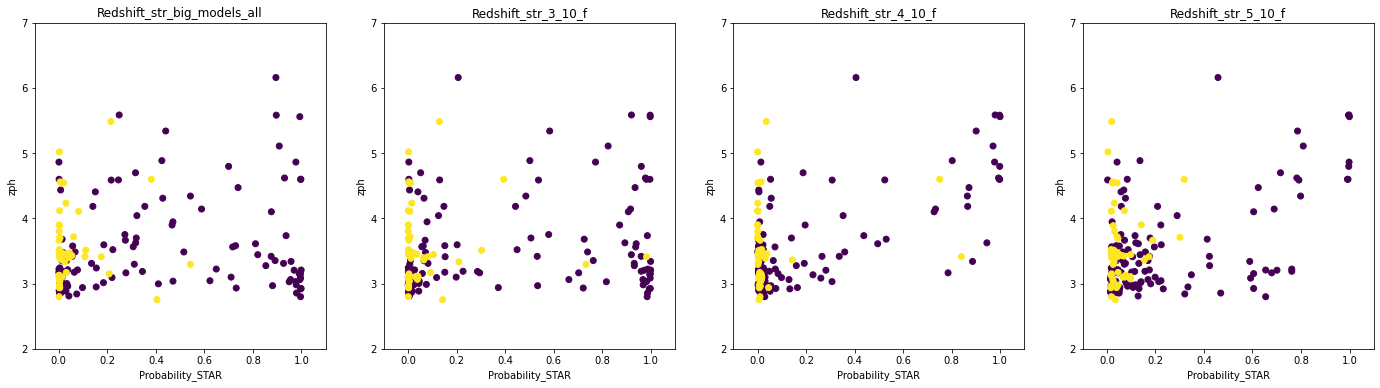

In [185]:
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
            '_10_f/models_all/'+mod, 
#             '__f23_lgbm_unbalance/models_all/'+mod,
#             'weak_weight2/models_all/'+mod
        ] 
}
plt_probability(df, models, overview, mod)

z>3                    z>4                   z>5               
          TP FN  TN  FP   T   N  TP FN  TN  FP  T   N  TP FN TN FP  T  N
Model                                                                   
standard  38  7  65  28  45  93   7  2  24   3  9  27   1  1  6  0  2  6
z>3       41  4  61  32  45  93   7  2  22   5  9  27   1  1  6  0  2  6
z>4       42  3  45  48  45  93   7  2  22   5  9  27   1  1  6  0  2  6
z>5       45  0  22  71  45  93   9  0  14  13  9  27   2  0  6  0  2  6

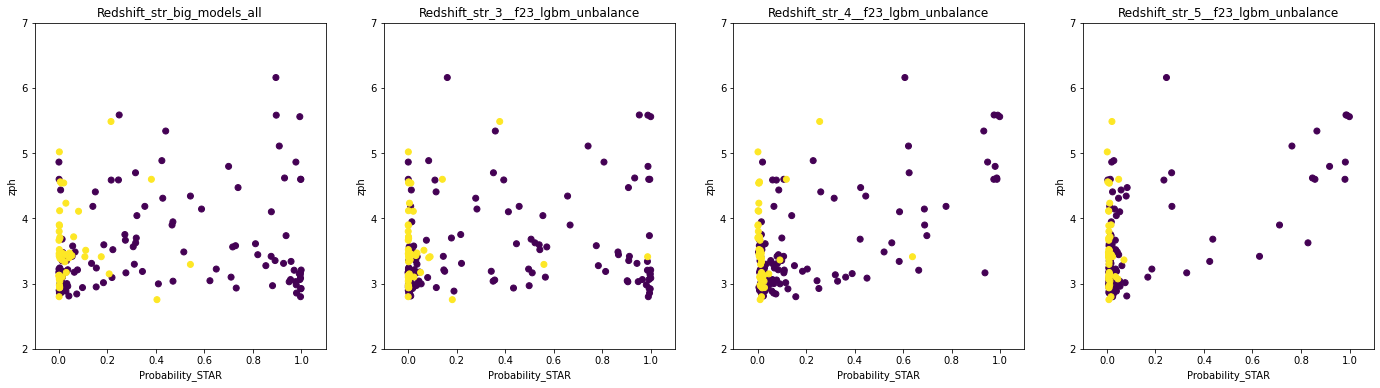

In [186]:
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
#             '_10_f/models_all/'+mod, 
            '__f23_lgbm_unbalance/models_all/'+mod,
#             'weak_weight2/models_all/'+mod
        ] 
}
plt_probability(df, models, overview, mod)

z>3                     z>4                   z>5               
          TP  FN  TN  FP   T   N  TP FN  TN  FP  T   N  TP FN TN FP  T  N
Model                                                                    
standard  38   7  65  28  45  93   7  2  24   3  9  27   1  1  6  0  2  6
z>3       41   4  50  43  45  93   8  1  15  12  9  27   2  0  4  2  2  6
z>4       44   1  32  61  45  93   9  0  18   9  9  27   2  0  6  0  2  6
z>5       16  29  59  34  45  93   7  2  15  12  9  27   2  0  6  0  2  6

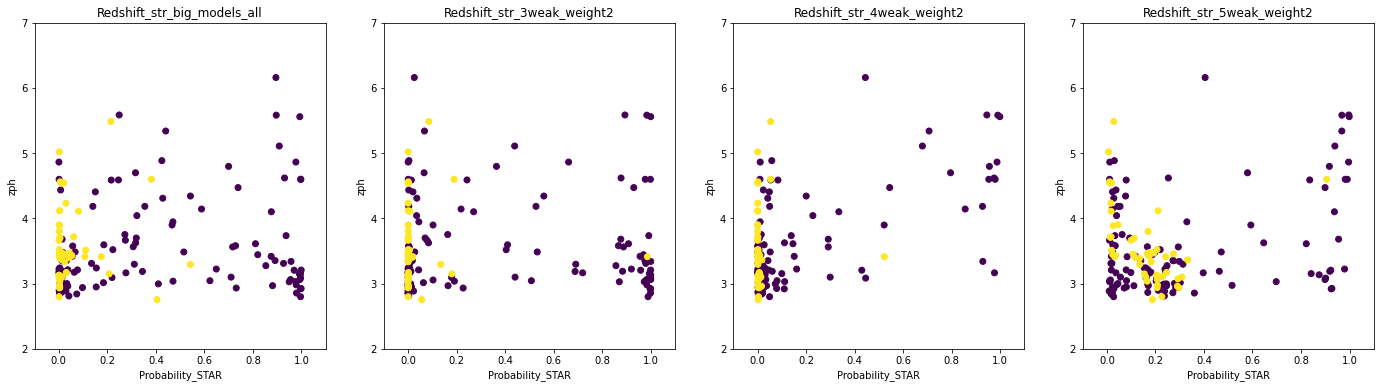

In [187]:
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
#             '_10_f/models_all/'+mod, 
#             '__f23_lgbm_unbalance/models_all/'+mod,
            'weak_weight2/models_all/'+mod
        ] 
}
plt_probability(df, models, overview, mod)

z>3                    z>4                   z>5               
          TP FN  TN  FP   T   N  TP FN  TN  FP  T   N  TP FN TN FP  T  N
Model                                                                   
standard  38  7  65  28  45  93   7  2  24   3  9  27   1  1  6  0  2  6
z>3       40  5  58  35  45  93   7  2  19   8  9  27   1  1  6  0  2  6
z>4       43  2  43  50  45  93   8  1  22   5  9  27   2  0  6  0  2  6
z>5       43  2  33  60  45  93   8  1  15  12  9  27   2  0  6  0  2  6

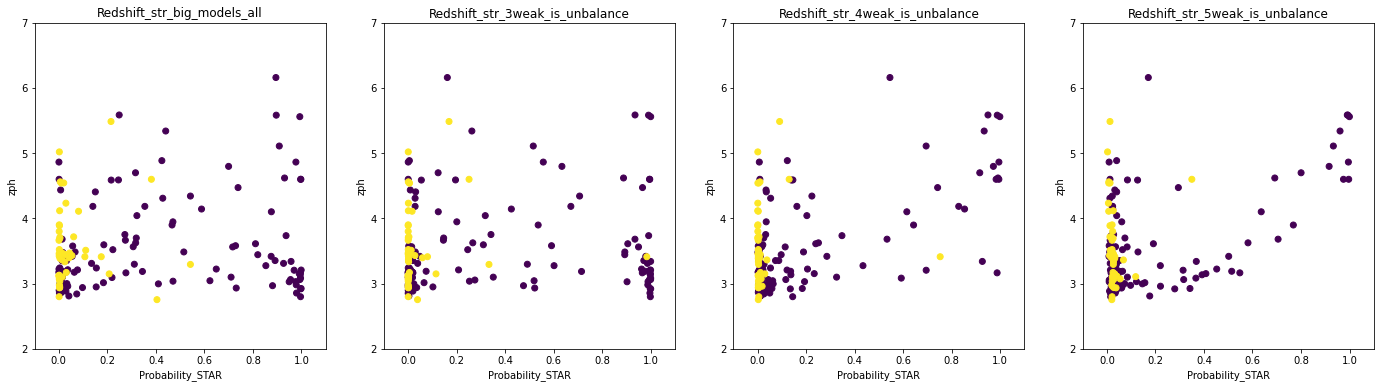

In [188]:
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
#             '_10_f/models_all/'+mod, 
#             '__f23_lgbm_unbalance/models_all/'+mod,
            'weak_is_unbalance/models_all/'+mod
        ] 
}
plt_probability(df, models, overview, mod)

z>3                    z>4                   z>5               
          TP FN  TN  FP   T   N  TP FN  TN  FP  T   N  TP FN TN FP  T  N
Model                                                                   
standard  38  7  65  28  45  93   7  2  24   3  9  27   1  1  6  0  2  6
z>3       41  4  53  40  45  93   8  1  17  10  9  27   2  0  5  1  2  6
z>4       43  2  41  52  45  93   8  1  23   4  9  27   2  0  6  0  2  6
z>5       42  3  47  46  45  93   8  1  21   6  9  27   2  0  6  0  2  6

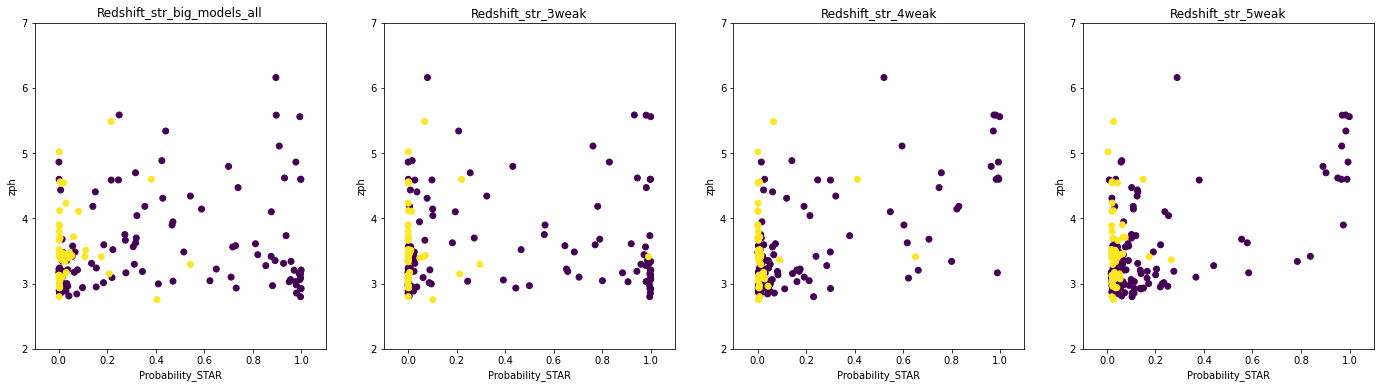

In [189]:
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
#             '_10_f/models_all/'+mod, 
#             '__f23_lgbm_unbalance/models_all/'+mod,
            'weak/models_all/'+mod
        ] 
}
plt_probability(df, models, overview, mod)

FileNotFoundError: [Errno 2] No such file or directory: '3weak_scale_pos_weight/models_all/not_j/features_sdssdr16+psdr2+all_decals8tr.pkl'

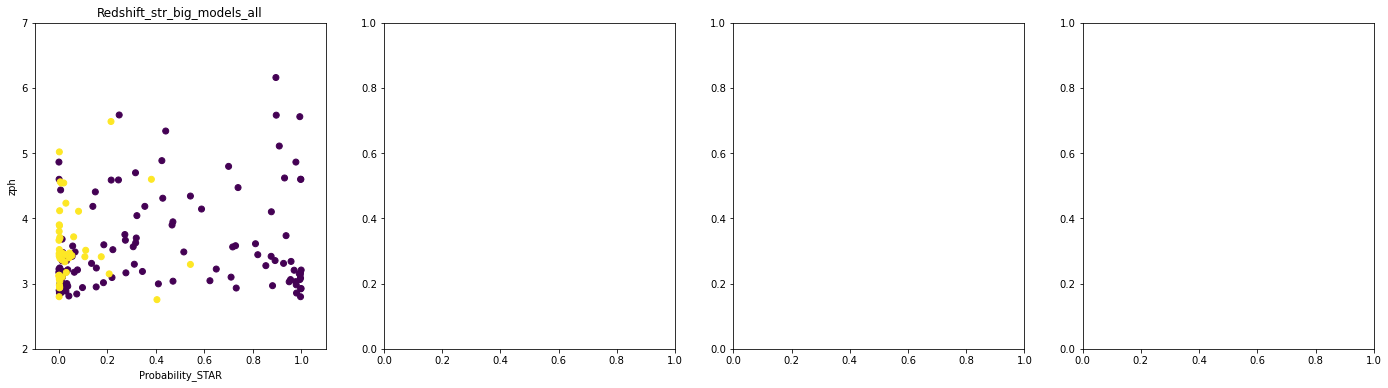

In [144]:
models = {
    'big': 
        ['big_models_all/'+mod],
    'weak': 
        [
#             '_10_f/models_all/'+mod, 
#             '__f23_lgbm_unbalance/models_all/'+mod,
            'weak_scale_pos_weight/models_all/'+mod
        ] 
}
plt_probability(df, models, overview, mod)

In [73]:
df

,NAME,RA,Dec,objid,t_objid,Prog,P1,zph,Redshift_str,Redshift_err,...,phot_is_test_qso,phot_is_test_star,phot_is_test_gal,phot_is_spec_sdss,phot_test_field,__nrow__,ProbabilitySgb_big35,ProbabilityQgb_big35,ProbabilityGgb_big35,Labelgb_big35
0,NaN,0.060000,17.605833,1237679456535773580,NaN,NaN,1.30,3.729,0.000,NaN,...,False,False,False,False,-,1,NaN,NaN,NaN,NaN
1,NaN,160.295000,60.460056,1237655370356621994,NaN,NaN,0.00,3.298,0.000,NaN,...,False,False,False,False,LH,2,0.820418,0.141572,0.038010,1.0
2,NaN,160.297500,58.884805,1237658304889815796,NaN,NaN,0.00,3.566,0.000,NaN,...,False,False,False,False,LH,3,0.042738,0.956138,0.001124,2.0
3,NaN,160.616666,60.089611,1237655369819750670,NaN,NaN,0.00,2.920,0.000,NaN,...,False,False,False,False,LH,4,0.997726,0.002120,0.000155,1.0
4,NaN,160.687500,56.162472,1237657772323701090,NaN,NaN,0.00,3.348,0.000,-1.000,...,False,False,False,False,LH,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,-,234,0.043523,0.954961,0.001516,2.0
234,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,-,235,NaN,NaN,NaN,NaN
235,NaN,276.985000,70.949722,193142769853920674,NaN,NaN,0.50,4.911,4.868,NaN,...,False,False,False,False,-,236,NaN,NaN,NaN,NaN
236,NaN,30.428333,-1.897222,1237678881033945854,NaN,NaN,-999.00,5.020,5.010,0.010,...,False,False,False,False,-,237,0.000216,0.999744,0.000040,2.0


<AxesSubplot:xlabel='ProbabilitySgb_big35', ylabel='zph'>

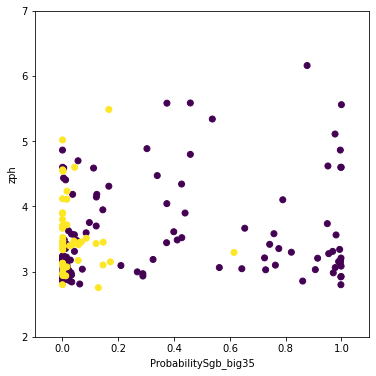

In [133]:
p = 'ProbabilitySgb_big35'
x = 'Redshift_str'
y = 'zph'
print_plt(df, p, y, ax=None, nProbability=x, xlim=[-0.1, 1.1], ylim=[2, 7])

In [9]:
# def CM(df11, df22, gb1, gb2, robust1, robust2, columns, file_name=None, data ='not_j', norm=False, one=False, feat=None):
    
#     if type(columns) == str:
#         print('str')
#         columns =[columns]
        
#     lalala = len(columns)
        
#     from sklearn.metrics import confusion_matrix
#     from sklearn.metrics import ConfusionMatrixDisplay
#     if feat is None:
#         X1, y1 = df11[columns+f[data][overview]].values, df11['class'].values #.replace({'class':classes}, inplace = True)
#         X2, y2 = df22[columns+f[data][overview]].values, df22['class'].values
#     else:
#         X1, y1 = df11[columns+feat].values, df11['class'].values #.replace({'class':classes}, inplace = True)
#         X2, y2 = df22[columns+feat].values, df22['class'].values
     

#     y_test = np.concatenate((y2, y1)) if not one else y1
#     y_pred = np.concatenate((gb1.predict(X2[:, lalala:] if robust1 is None 
#                                                                                 else robust1.transform(X2[:, lalala:])), 
#                                                      gb2.predict(X1[:, lalala:] if robust2 is None 
#                                                                                 else robust2.transform(X1[:, lalala:])))) if not one else gb1.predict(X1[:, lalal:] if robust1 is None else robust1.transform(X1[:, lalala:]))
#     y_pred_proba = np.concatenate((gb1.predict_proba(X2[:, lalala:] if robust1 is None 
#                                                                                 else robust1.transform(X2[:, lalala:])), 
#                                                      gb2.predict_proba(X1[:, lalala:] if robust2 is None 
#                                                                                 else robust2.transform(X1[:, lalala:])))) if not one else gb1.predict_proba(X1[:, lalal:] if robust1 is None else robust1.transform(X1[:, lalala:]))
    
    
#     y_pred[y_pred == 3] = 2

#     p = pd.DataFrame({
#         'Redshift_str' : np.concatenate([df11['Redshift_str'].values, df22['Redshift_str'].values], axis=0),
#         'zph' :          np.concatenate([df11['zph'].values, df22['zph'].values], axis=0),
#         'ProbabilityQgb_big35': y_pred_proba[:, 1]
#                      })
#     print_plt(p.dropna(), 'Redshift_str', 'zph')
#     end = []#'%TP', '%FP', '%TN', '%FN', 'T', 'N'    tn, fp, fn, tp
#     tn, fp, fn, tp = np.around(confusion_matrix(y_test, y_pred, normalize='true'), 3).ravel()
#     end += [tp, fn, tn, fp]
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize=None).ravel()
#     end += [fn + tp, tn + fp]
    
#     P = TP + FP
#     N = TN + FN

#     return end

In [15]:
rec = {}
col = ['Model', '%TP', '%FN', '%TN', '%FP', 'T', 'N']
columns = ['Redshift_str', 'zph']

rec['z>3'] = pd.DataFrame([], columns=col)
rec['z>4'] = pd.DataFrame([], columns=col)
rec['z>5'] = pd.DataFrame([], columns=col)


for i in [3, 4, 5]:
    #df = pd.read_pickle(f'./data/{i}weak.pkl_gz', compression='gzip')
    df1 = df.loc[df['zph']> i]
    df2 = df.loc[df['zph']> i]
    model = 'gb'
    weak = f'{i}weak_is_unbalance'

    for data in ['not_j']:
        for overview in ["sdssdr16+psdr2+all_decals8tr"]:#f[data].keys():
            

            df11 = df1[columns+f[data][overview]+['class']].dropna()
            df22 = df2[columns+f[data][overview]+['class']].dropna()

            for j in range(3, 6):
                
                weak = f'{j}weak'

                model1, robust1 = joblib.load(weak+'/models0/'+ data +'/model_'+overview+'.pkl'), joblib.load(weak+'/models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
                model2, robust2 = joblib.load(weak+'/models1/'+ data +'/model_'+overview+'.pkl'), joblib.load(weak+'/models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

                cm = CM(df11, df22, model1, model2, robust1, robust2, columns, None, data=data)
                
                rec[f'z>{i}'] = rec[f'z>{i}'].append(pd.DataFrame([[f'z>{j}'] + cm], columns=col), ignore_index=True)

            
            model1, robust1 = joblib.load('./big_models0/'+ data +'/model_'+overview+'.pkl'), joblib.load('models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
            model2, robust2 = joblib.load('./big_models1/'+ data +'/model_'+overview+'.pkl'), joblib.load('models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

            cm = CM(df11, df22, model1, model2, robust1, robust2, columns, None, data=data)
                
            rec[f'z>{i}'] = rec[f'z>{i}'].append(pd.DataFrame([[f'standard'] + cm], columns=col), ignore_index=True)

for i, r in rec.items():
    rec[i] = r.set_index('Model')
pd.concat(rec, axis=1).sort_index()

KeyError: "['class'] not in index"

# Тест на реальной выборке

In [23]:
!ls /data/SRGz/follow-up_sample/srgz-ls

addcorr_buf
buf
data
part-00000.best.x0.gz_pkl
part-00000.features.3xmmdr8.gz_pkl
part-00000.features.flesch21v72.gz_pkl
part-00000.features.galex.gz_pkl
part-00000.features.gz_pkl
part-00000.features.rosatbl.gz_pkl
part-00000.features.sdssspdr16.gz_pkl
part-00000.features.sdssspdr16Qsuperset.gz_pkl
part-00000.features.sdssspdr16Qv4.gz_pkl
part-00000.features.uhs1v1.gz_pkl
part-00000.predictions.gb_big.gz_pkl
part-00000.predictions.x0.gz_pkl
part-00000.preds.gb_big19.gz_pkl
part-00000.preds.gb_big21.gz_pkl
part-00000.preds.gb_big22.gz_pkl
part-00000.preds.gb_big35.gz_pkl


In [11]:
path_to_files = '/data/SRGz/follow-up_sample/srgz-ls'
condition = 'part-00000.features.*.gz_pkl'
df = read_tables(path_to_files, condition)

Exception: Unsupported format of table

In [52]:
for i in df.columns:
    print(i)

NAME
RA
Dec
objid
t_objid
Prog
P1
zph
Redshift_str
Redshift_err
Mag
ST
Observed
Status
Locked
Telescope(name)
Setup(telescope, grizm, slit, texp, status)
Filter(telescope, color, texp, status)
ntotal_spec
observed_by_telescope
time_spent
Goal
ObserverNotes
__workxid__
ls_sep_input
ls_release
ls_brickid
ls_brickname
ls_objid
ls_brick_primary
ls_brightblob
ls_maskbits
ls_type
ls_ra
ls_dec
ls_ra_ivar
ls_dec_ivar
ls_bx
ls_by
ls_ebv
ls_mjd_min
ls_mjd_max
ls_ref_cat
ls_ref_id
ls_pmra
ls_pmdec
ls_parallax
ls_pmra_ivar
ls_pmdec_ivar
ls_parallax_ivar
ls_ref_epoch
ls_gaia_pointsource
ls_gaia_phot_g_mean_mag
ls_gaia_phot_g_mean_flux_over_error
ls_gaia_phot_g_n_obs
ls_gaia_phot_bp_mean_mag
ls_gaia_phot_bp_mean_flux_over_error
ls_gaia_phot_bp_n_obs
ls_gaia_phot_rp_mean_mag
ls_gaia_phot_rp_mean_flux_over_error
ls_gaia_phot_rp_n_obs
ls_gaia_phot_variable_flag
ls_gaia_astrometric_excess_noise
ls_gaia_astrometric_excess_noise_sig
ls_gaia_astrometric_n_obs_al
ls_gaia_astrometric_n_good_obs_al
ls_gaia_as

In [49]:
print(df1.columns)

Index(['zoo_best-x0_z_pdf', 'zoo_best-x0_z_max', 'zoo_best-x0_z_maxConf',
       'zoo_best-x0_z_max_DL_cm', 'zoo_best-x0_z_max_Lx',
       'zoo_best-x0_z_max_Lx_err', 'zoo_best-x0_ci1a_68',
       'zoo_best-x0_ci1b_68', 'zoo_best-x0_ci1a_68_DL_cm',
       'zoo_best-x0_ci1b_68_DL_cm', 'zoo_best-x0_ci1a_68_Lx',
       'zoo_best-x0_ci1b_68_Lx', 'zoo_best-x0_ci1a_68_Lx_err',
       'zoo_best-x0_ci1b_68_Lx_err', 'zoo_best-x0_ci1a_90',
       'zoo_best-x0_ci1b_90', 'zoo_best-x0_ci1a_90_DL_cm',
       'zoo_best-x0_ci1b_90_DL_cm', 'zoo_best-x0_ci1a_90_Lx',
       'zoo_best-x0_ci1b_90_Lx', 'zoo_best-x0_ci1a_90_Lx_err',
       'zoo_best-x0_ci1b_90_Lx_err', 'zoo_best-x0_ci1a_95',
       'zoo_best-x0_ci1b_95', 'zoo_best-x0_ci1a_95_DL_cm',
       'zoo_best-x0_ci1b_95_DL_cm', 'zoo_best-x0_ci1a_95_Lx',
       'zoo_best-x0_ci1b_95_Lx', 'zoo_best-x0_ci1a_95_Lx_err',
       'zoo_best-x0_ci1b_95_Lx_err', 'zoo_best-x0_model_id'],
      dtype='object')


In [12]:
!python3 /data/SRGz/stars/clf/clf_x-ray.py\
        --inputFile /data/SRGz/follow-up_sample/srgz-ls/part-00000.features.gz_pkl\
        --outputDir ./\
        --modelsSeries gb_big\
        --modelsIds 35

Predictions: 100%|████████████████████████████████| 1/1 [00:00<00:00, 24.05it/s]


In [65]:
!ls ./buf

part-00000.features.gz_pkl  part-00000.preds.gb_big35.gz_pkl


In [87]:
read_table('./buf/part-00000.preds.gb_big35.gz_pkl')

,ProbabilitySgb_big35,ProbabilityQgb_big35,ProbabilityGgb_big35,Labelgb_big35
__tempid__,,,,
1,0.820418,0.141572,0.038010,1
2,0.042738,0.956138,0.001124,2
3,0.997726,0.002120,0.000155,1
5,0.006622,0.992995,0.000383,2
6,0.288149,0.709663,0.002188,2
...,...,...,...,...
230,0.001449,0.998496,0.000055,2
231,0.000354,0.999581,0.000065,2
233,0.043523,0.954961,0.001516,2


In [89]:
read_table('./buf/part-00000.features.gz_pkl')

,NAME,RA,Dec,objid,t_objid,Prog,P1,zph,Redshift_str,Redshift_err,...,phot_is_train_gal,phot_is_test_xxln_m16,phot_is_test_s82x_l19,phot_is_test_s82x_a17,phot_is_test_qso,phot_is_test_star,phot_is_test_gal,phot_is_spec_sdss,phot_test_field,__nrow__
0,NaN,0.060000,17.605833,1237679456535773580,NaN,NaN,1.30,3.729,0.000,NaN,...,False,False,False,False,False,False,False,False,-,1
1,NaN,160.295000,60.460056,1237655370356621994,NaN,NaN,0.00,3.298,0.000,NaN,...,False,False,False,False,False,False,False,False,LH,2
2,NaN,160.297500,58.884805,1237658304889815796,NaN,NaN,0.00,3.566,0.000,NaN,...,False,False,False,False,False,False,False,False,LH,3
3,NaN,160.616666,60.089611,1237655369819750670,NaN,NaN,0.00,2.920,0.000,NaN,...,False,False,False,False,False,False,False,False,LH,4
4,NaN,160.687500,56.162472,1237657772323701090,NaN,NaN,0.00,3.348,0.000,-1.000,...,False,False,False,False,False,False,False,False,LH,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,False,False,False,False,-,234
234,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,False,False,False,False,-,235
235,NaN,276.985000,70.949722,193142769853920674,NaN,NaN,0.50,4.911,4.868,NaN,...,False,False,False,False,False,False,False,False,-,236
236,NaN,30.428333,-1.897222,1237678881033945854,NaN,NaN,-999.00,5.020,5.010,0.010,...,False,False,False,False,False,False,False,False,-,237


In [13]:
df = read_tables(['./buf/part-00000.features.gz_pkl', './buf/part-00000.preds.gb_big35.gz_pkl'], 1)
df

,NAME,RA,Dec,objid,t_objid,Prog,P1,zph,Redshift_str,Redshift_err,...,phot_is_test_qso,phot_is_test_star,phot_is_test_gal,phot_is_spec_sdss,phot_test_field,__nrow__,ProbabilitySgb_big35,ProbabilityQgb_big35,ProbabilityGgb_big35,Labelgb_big35
0,NaN,0.060000,17.605833,1237679456535773580,NaN,NaN,1.30,3.729,0.000,NaN,...,False,False,False,False,-,1,NaN,NaN,NaN,NaN
1,NaN,160.295000,60.460056,1237655370356621994,NaN,NaN,0.00,3.298,0.000,NaN,...,False,False,False,False,LH,2,0.820418,0.141572,0.038010,1.0
2,NaN,160.297500,58.884805,1237658304889815796,NaN,NaN,0.00,3.566,0.000,NaN,...,False,False,False,False,LH,3,0.042738,0.956138,0.001124,2.0
3,NaN,160.616666,60.089611,1237655369819750670,NaN,NaN,0.00,2.920,0.000,NaN,...,False,False,False,False,LH,4,0.997726,0.002120,0.000155,1.0
4,NaN,160.687500,56.162472,1237657772323701090,NaN,NaN,0.00,3.348,0.000,-1.000,...,False,False,False,False,LH,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,-,234,0.043523,0.954961,0.001516,2.0
234,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,-,235,NaN,NaN,NaN,NaN
235,NaN,276.985000,70.949722,193142769853920674,NaN,NaN,0.50,4.911,4.868,NaN,...,False,False,False,False,-,236,NaN,NaN,NaN,NaN
236,NaN,30.428333,-1.897222,1237678881033945854,NaN,NaN,-999.00,5.020,5.010,0.010,...,False,False,False,False,-,237,0.000216,0.999744,0.000040,2.0


In [83]:
#df = read_table('/data/SRGz/follow-up_sample/srgz-ls/part-00000.features.gz_pkl')
df = read_table('./buf/part-00000.features.gz_pkl')
df

,NAME,RA,Dec,objid,t_objid,Prog,P1,zph,Redshift_str,Redshift_err,...,phot_is_train_gal,phot_is_test_xxln_m16,phot_is_test_s82x_l19,phot_is_test_s82x_a17,phot_is_test_qso,phot_is_test_star,phot_is_test_gal,phot_is_spec_sdss,phot_test_field,__nrow__
0,NaN,0.060000,17.605833,1237679456535773580,NaN,NaN,1.30,3.729,0.000,NaN,...,False,False,False,False,False,False,False,False,-,1
1,NaN,160.295000,60.460056,1237655370356621994,NaN,NaN,0.00,3.298,0.000,NaN,...,False,False,False,False,False,False,False,False,LH,2
2,NaN,160.297500,58.884805,1237658304889815796,NaN,NaN,0.00,3.566,0.000,NaN,...,False,False,False,False,False,False,False,False,LH,3
3,NaN,160.616666,60.089611,1237655369819750670,NaN,NaN,0.00,2.920,0.000,NaN,...,False,False,False,False,False,False,False,False,LH,4
4,NaN,160.687500,56.162472,1237657772323701090,NaN,NaN,0.00,3.348,0.000,-1.000,...,False,False,False,False,False,False,False,False,LH,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,False,False,False,False,-,234
234,NaN,270.221666,42.214722,158652702219308424,NaN,NaN,0.10,4.600,4.767,0.009,...,False,False,False,False,False,False,False,False,-,235
235,NaN,276.985000,70.949722,193142769853920674,NaN,NaN,0.50,4.911,4.868,NaN,...,False,False,False,False,False,False,False,False,-,236
236,NaN,30.428333,-1.897222,1237678881033945854,NaN,NaN,-999.00,5.020,5.010,0.010,...,False,False,False,False,False,False,False,False,-,237


In [98]:
df[df['Redshift_str'] < 1.0]

,NAME,RA,Dec,objid,t_objid,Prog,P1,zph,Redshift_str,Redshift_err,...,phot_is_test_qso,phot_is_test_star,phot_is_test_gal,phot_is_spec_sdss,phot_test_field,__nrow__,ProbabilitySgb_big35,ProbabilityQgb_big35,ProbabilityGgb_big35,Labelgb_big35
0,NaN,0.060000,17.605833,1237679456535773580,NaN,NaN,1.30,3.729,0.0000,NaN,...,False,False,False,False,-,1,NaN,NaN,NaN,NaN
1,NaN,160.295000,60.460056,1237655370356621994,NaN,NaN,0.00,3.298,0.0000,NaN,...,False,False,False,False,LH,2,0.820418,0.141572,0.038010,1.0
2,NaN,160.297500,58.884805,1237658304889815796,NaN,NaN,0.00,3.566,0.0000,NaN,...,False,False,False,False,LH,3,0.042738,0.956138,0.001124,2.0
3,NaN,160.616666,60.089611,1237655369819750670,NaN,NaN,0.00,2.920,0.0000,NaN,...,False,False,False,False,LH,4,0.997726,0.002120,0.000155,1.0
4,NaN,160.687500,56.162472,1237657772323701090,NaN,NaN,0.00,3.348,0.0000,-1.0000,...,False,False,False,False,LH,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,NaN,262.735833,72.214444,1237656565430945037,NaN,NaN,1.71,5.340,0.5514,0.0003,...,False,False,False,False,-,166,0.537050,0.462382,0.000569,1.0
166,NaN,18.155417,24.855556,1237666091129766810,NaN,NaN,1.50,3.596,0.5693,0.0002,...,False,False,False,False,-,167,0.084807,0.612204,0.302989,2.0
167,NaN,342.337500,15.291944,1237678600224047177,NaN,NaN,1.59,3.056,0.6580,NaN,...,False,False,False,False,-,168,0.017531,0.982442,0.000027,2.0
168,NaN,161.650000,59.648361,1237653616934388723,NaN,NaN,0.00,4.473,0.6652,0.0022,...,False,False,False,False,LH,169,0.339679,0.659824,0.000497,2.0


In [116]:
df.loc[df['Redshift_str'] == 0.0]

,NAME,RA,Dec,objid,t_objid,Prog,P1,zph,Redshift_str,Redshift_err,...,phot_is_test_qso,phot_is_test_star,phot_is_test_gal,phot_is_spec_sdss,phot_test_field,__nrow__,ProbabilitySgb_big35,ProbabilityQgb_big35,ProbabilityGgb_big35,Labelgb_big35
0,NaN,0.060000,17.605833,1237679456535773580,NaN,NaN,1.30,3.729,0.0,NaN,...,False,False,False,False,-,1,NaN,NaN,NaN,NaN
1,NaN,160.295000,60.460056,1237655370356621994,NaN,NaN,0.00,3.298,0.0,NaN,...,False,False,False,False,LH,2,0.820418,0.141572,0.038010,1.0
2,NaN,160.297500,58.884805,1237658304889815796,NaN,NaN,0.00,3.566,0.0,NaN,...,False,False,False,False,LH,3,0.042738,0.956138,0.001124,2.0
3,NaN,160.616666,60.089611,1237655369819750670,NaN,NaN,0.00,2.920,0.0,NaN,...,False,False,False,False,LH,4,0.997726,0.002120,0.000155,1.0
4,NaN,160.687500,56.162472,1237657772323701090,NaN,NaN,0.00,3.348,0.0,-1.0,...,False,False,False,False,LH,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,NaN,270.604583,45.959611,1237655748858413601,NaN,NaN,-999.00,3.351,0.0,NaN,...,False,False,False,False,-,147,0.005878,0.993616,0.000507,2.0
147,NaN,311.249583,7.786531,1237652985035555732,NaN,NaN,-999.00,3.003,0.0,NaN,...,False,False,False,False,-,148,NaN,NaN,NaN,NaN
148,NaN,311.249583,7.786531,1237652985035555732,NaN,NaN,-999.00,3.003,0.0,NaN,...,False,False,False,False,-,149,NaN,NaN,NaN,NaN
149,NaN,309.775833,9.935833,119923097760693830,NaN,NaN,0.17,4.600,0.0,NaN,...,False,False,False,False,-,150,NaN,NaN,NaN,NaN


In [123]:
sum(df['Redshift_str'] == 0.0)

151

In [124]:
df['class'] = (df['Redshift_str'] != 0.0) * 1 + 1

In [139]:
sum(df['class'] > 1), sum(df['class'] == 1)

(87, 151)

In [134]:
rec = {}
col = ['Model', '%TP', '%FN', '%TN', '%FP', 'T', 'N']

rec['z>3'] = pd.DataFrame([], columns=col)
rec['z>4'] = pd.DataFrame([], columns=col)
rec['z>5'] = pd.DataFrame([], columns=col)


for i in [3, 4, 5]:
    #df = pd.read_pickle(f'./data/{i}weak.pkl_gz', compression='gzip')
    df1 = df
    df2 = df
    model = 'gb'
    weak = f'{i}weak_is_unbalance'

    for data in ['not_j']:
        for overview in ["sdssdr16+psdr2+all_decals8tr"]:#f[data].keys():
            

            df11 = df1[[column]+f[data][overview]+['class']].dropna()
            df22 = df2[[column]+f[data][overview]+['class']].dropna()

            for j in range(3, 6):
                
                weak = f'{j}weak'

                model1, robust1 = joblib.load(weak+'/models0/'+ data +'/model_'+overview+'.pkl'), joblib.load(weak+'/models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
                model2, robust2 = joblib.load(weak+'/models1/'+ data +'/model_'+overview+'.pkl'), joblib.load(weak+'/models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

                cm = CM(df11, df22, model1, model2, robust1, robust2, column, None, data=data)
                
                rec[f'z>{i}'] = rec[f'z>{i}'].append(pd.DataFrame([[f'z>{j}'] + cm], columns=col), ignore_index=True)

            
            model1, robust1 = joblib.load('big_models0/'+ data +'/model_'+overview+'.pkl'), joblib.load('models0/'+ data +'/'+overview+'_robust_for_gb.pkl')
            model2, robust2 = joblib.load('big_models1/'+ data +'/model_'+overview+'.pkl'), joblib.load('models1/'+ data +'/'+overview+'_robust_for_gb.pkl')

            cm = CM(df11, df22, model1, model2, robust1, robust2, column, None, data=data)
                
            rec[f'z>{i}'] = rec[f'z>{i}'].append(pd.DataFrame([[f'standard'] + cm], columns=col), ignore_index=True)

for i, r in rec.items():
    rec[i] = r.set_index('Model')
pd.concat(rec, axis=1).sort_index()

z>3                                   z>4                       \
            %TP    %FN    %TN    %FP    T    N    %TP    %FN    %TN    %FP   
Model                                                                        
standard  0.680  0.320  0.577  0.423  150  194  0.680  0.320  0.577  0.423   
z>3       0.847  0.153  0.381  0.619  150  194  0.847  0.153  0.381  0.619   
z>4       0.913  0.087  0.160  0.840  150  194  0.913  0.087  0.160  0.840   

                      z>5                                 
            T    N    %TP    %FN    %TN    %FP    T    N  
Model                                                     
standard  150  194  0.680  0.320  0.577  0.423  150  194  
z>3       150  194  0.847  0.153  0.381  0.619  150  194  
z>4       150  194  0.913  0.087  0.160  0.840  150  194